In [114]:
import pandas as pd
import numpy as np
import xarray as xr
import requests
%matplotlib inline
%matplotlib notebook
import matplotlib.pylab as plt
from scipy.interpolate import griddata
from cartopy import config
import cartopy.crs as ccrs
from shapely.geometry import Polygon
import shapely.geometry as geometry
from geojson import Polygon
import pymongo
import multiprocessing as mp
from numpy import array_split
from datetime import datetime
from datetime import timedelta
import time
import pdb
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import math

In [49]:
def get_ar_by_date(dateStr):
    url = 'http://localhost:3000/arShapes/findByDate?date={}'.format(dateStr)
    resp = requests.get(url)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    profile = resp.json()
    return profile

In [198]:
date = '2010-01-01T00:00:00Z'
def make_year_dates(year):
    dates =  pd.date_range(start='1/1/'+str(year), end='1/1/'+str(year+1), freq='3H') 
    return dates[:-1]

def test_selection_profiles(startDate, endDate, shape, _id):
    "sends out AR _id if query failed, otherwise, true."
    baseURL = 'http://localhost:3000/selection/profiles/map'
    startDateQuery = '?startDate=' + startDate
    endDateQuery = '&endDate=' + endDate
    shapeQuery = '&shape='+shape
    url = baseURL + startDateQuery + endDateQuery + shapeQuery
    resp = requests.get(url)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return _id
    else:
        return None
    
format_date_api = lambda date: datetime.strftime(date, "%Y-%m-%dT%H:%M:%SZ")


def transform_shape(shape):
    transformedShape= []
    for point in shape:
        lng = point[0] % 360
        if (lng < -180):
            lng = 180 + lng % 180;
        if (lng > 180):
            lng = -180 + lng % 180;
        tpoint = [lng, point[1]];
        transformedShape.append(tpoint);
    return([transformedShape])


def test_shapes(ars, startDate, endDate):
    failedArs = []
    for idx, ar in enumerate(ars):
        tshape = transform_shape(ar['geoLocation']['coordinates'])
        shape = str(tshape).replace(' ', '')
        fail_id = test_selection_profiles(startDate, endDate, shape, ar['_id'])
        if fail_id:
            failedArs.append(ar)
    return failedArs

In [199]:
year = 2010
dates = make_year_dates(year)

In [200]:
date = dates[0]
ars = get_ar_by_date(format_date_api(date))
ar = ars[2]

In [222]:
fa = []
nArTested = 0
for date in dates:
    startDate = format_date_api(date - timedelta(days=3))
    endDate = format_date_api(date + timedelta(days=3))
    ars = get_ar_by_date(format_date_api(date))
    failedArs = test_shapes(ars, startDate, endDate)
    if len(failedArs) > 0:
        fa += failedArs
    nArTested += len(ars)
        

KeyboardInterrupt: 

In [223]:
print(len(fa)/float(nArTested))
import csv
with open('output.csv','w') as result_file:
    wr = csv.writer(result_file)
    wr.writerows([fa])

0.01076555023923445


In [ ]:
fa

In [230]:
def format_ars(ars):
    out = ars.copy()
    for ar in out:
        coords = ar['geoLocation']['coordinates']
        del ar['geoLocation']
        longs, lats = list(zip(*coords))
        ar['coords'] = coords
        ar['longs'] = list(longs)
        ar['lats'] = list(lats)
    return out
ffar = format_ars(fa)
arDf = pd.DataFrame(ffar)

KeyError: 'geoLocation'

<IPython.core.display.Javascript object>


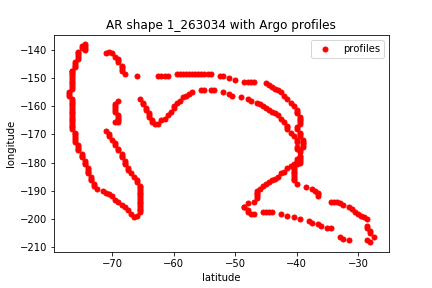

<IPython.core.display.Javascript object>


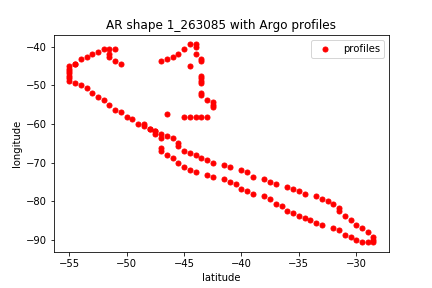

<IPython.core.display.Javascript object>


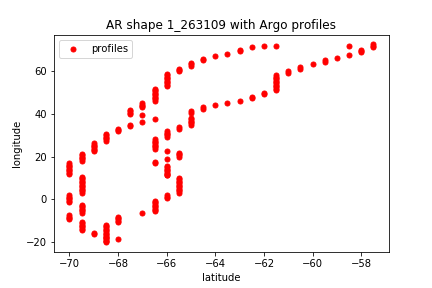

<IPython.core.display.Javascript object>


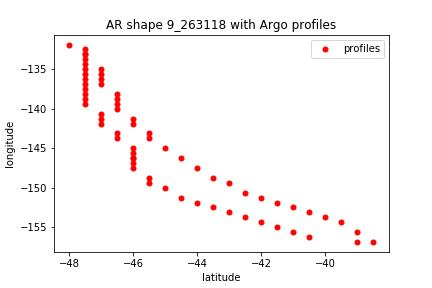

<IPython.core.display.Javascript object>


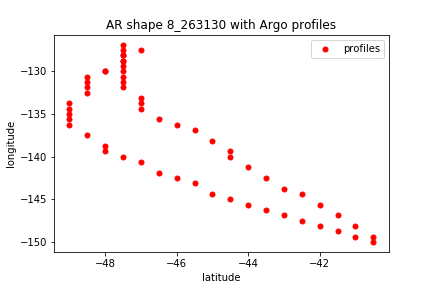

<IPython.core.display.Javascript object>


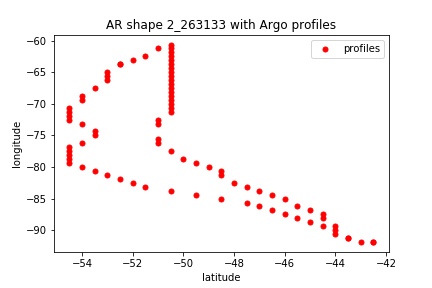

<IPython.core.display.Javascript object>


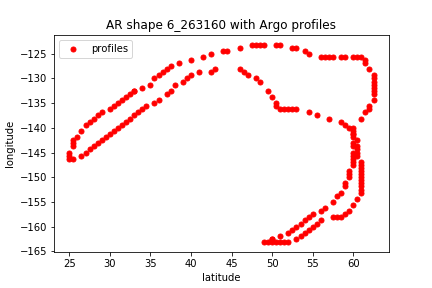

<IPython.core.display.Javascript object>


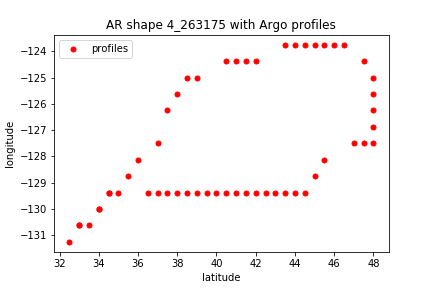

<IPython.core.display.Javascript object>


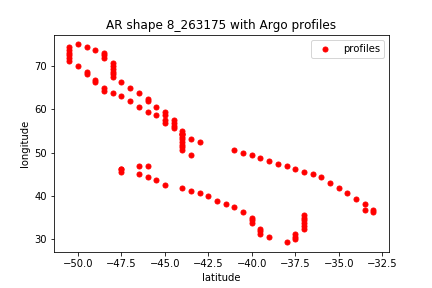

<IPython.core.display.Javascript object>


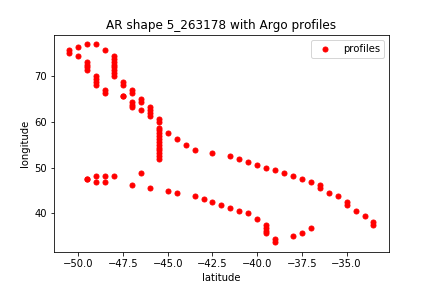

<IPython.core.display.Javascript object>


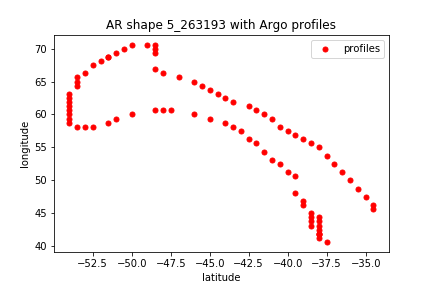

<IPython.core.display.Javascript object>


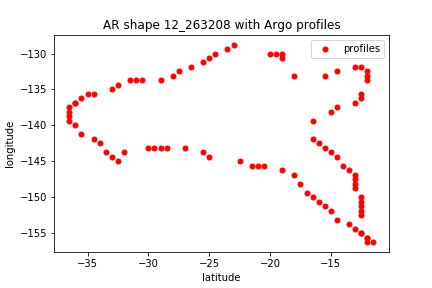

<IPython.core.display.Javascript object>


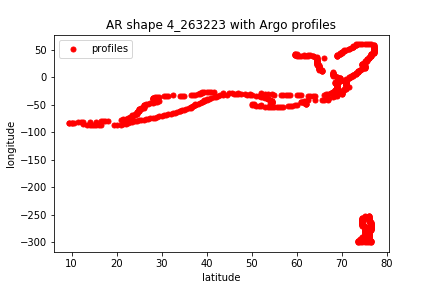

<IPython.core.display.Javascript object>


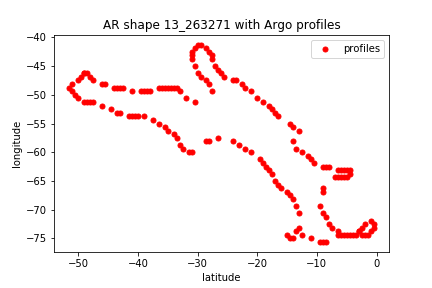

<IPython.core.display.Javascript object>


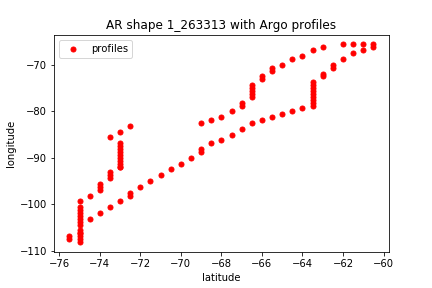

<IPython.core.display.Javascript object>


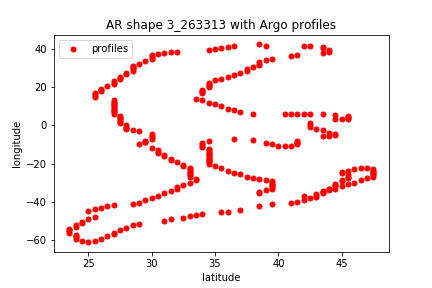

<IPython.core.display.Javascript object>


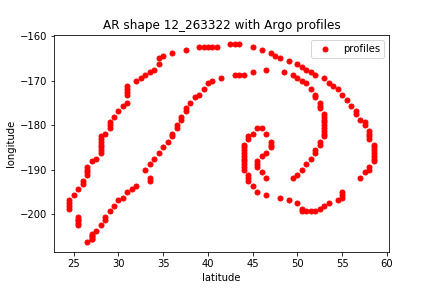

<IPython.core.display.Javascript object>


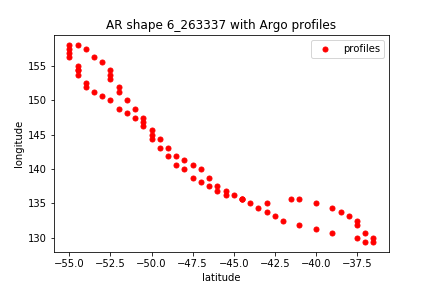

In [242]:
def plot_profiles_and_ar(ar):
    fig = plt.figure()
    axes = plt.axes()
    ax, ay = ar.lats, ar.longs
    axes.scatter(ax,ay,marker='o',c='r',s=25)
    axes.set_title('AR shape {} with Argo profiles'.format(ar.id))
    axes.set_ylabel('longitude')
    axes.set_xlabel('latitude')
    axes.legend(['profiles', 'ar shape'])
    return fig
for row in arDf.itertuples():
    fig = plot_profiles_and_ar(row)

In [239]:
row.id

'1_263034'